# BIG MART SALES PREDICTION

In this project, I'm trying to predict product sales based on product features and store information. To forecast sales, I compared different regression models: Linear Regression, Random Forest and XGBoost.

In [81]:
#Loading all the relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
import math

import shap

## Data Overview

In [82]:
df = pd.read_csv('Data/train.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Variable Description
- *Item_Identifier*: Unique product ID
- *Item_Weight*: Weight of product
- *Item_Fat_Content*: Whether the product is low fat or not
- *Item_Visibility*: The % of the total display area of all products in a store allocated to the particular product
- *Item_Type*: The category to which the product belongs
- *Item_MRP*: Maximum Retail Price (list price) of the product
- *Outlet_Identifier*: Unique store ID
- *Outlet_Establishment_Year*: The year in which the store was established
- *Outlet_Size*: The size of the store in terms of ground area covered
- *Outlet_Location_Type*: The type of city in which the store is located
- *Outlet_Type*: Whether the outlet is just a grocery store or some sort of supermarket
- *Item_Outlet_Sales*: sales of the product in t particular store. This is the outcome variable to be predicted.

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


The dataset consists of **8,523 rows** and **12 columns**. It contains both numerical and categorical variables, which makes it suitable for a regression problem.
- Target varible: *Item_Outlet_Sales*
- Independent variables:
  + Product-related features: *Item_Weight, Item_Fat_Content, Item_Visibility, Item_Type, Item_MRP*
  + Outlet-related features: *Outlet_Establishment_Year, Outlet_Size, Outlet_Location_Type, Outlet_Type*
  + Identifier columns : *Item_Identifier and Outlet_Identifier*

In [84]:
df.isnull().mean()* 100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

*Item_Weight* and *Outlet_Size* contain missing values, at a scale of 17.16% and 28.28%, respectively

In [85]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


The feature distributions appear relatively uniform overall. However, *Item_Visibility* contains unusually small values, including zeros

## Explore Data Analysis

In [86]:
# feature engineering - Outlet_Age
df['Outlet_Age'] = 2025 - df['Outlet_Establishment_Year']

In [87]:
# dropping the 'Outlet_Establishment_Year' column as it is no longer needed
df = df.drop(columns=['Outlet_Establishment_Year'])

In [88]:
# remove Item_Identifier column
df = df.drop(columns='Item_Identifier')

#### Univariate Analysis

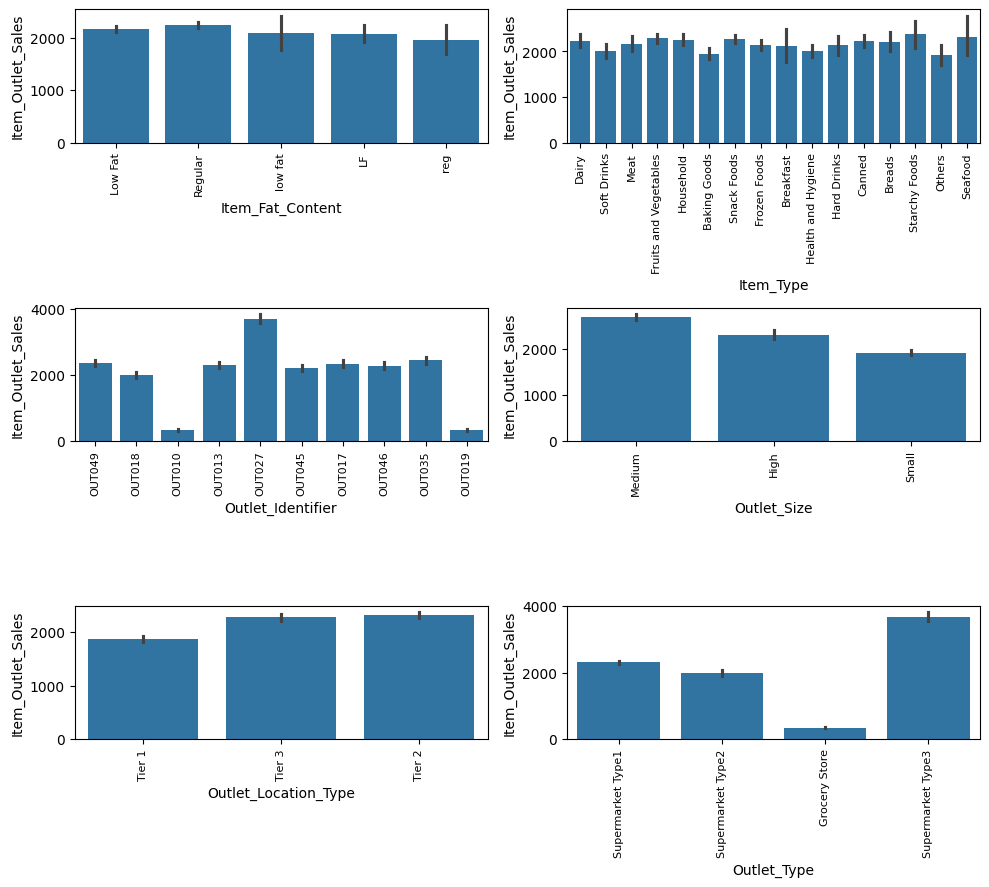

In [89]:
cat_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

fig, axes = plt.subplots(3,2, figsize=(10,9))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.barplot(x=col, y='Item_Outlet_Sales', data=df, ax=axes[i])
    axes[i].tick_params(axis='x', rotation=90, labelsize=8)

plt.tight_layout()
plt.show()

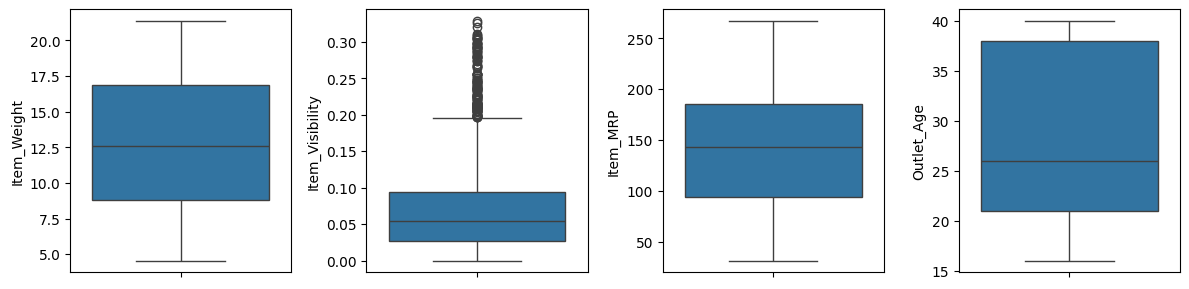

In [90]:
num_cols = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Age']

fig, axes = plt.subplots(1,4, figsize=(12, 3))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(df[col], ax=axes[i])

plt.tight_layout()
plt.show()

#### Multivariate Analysis

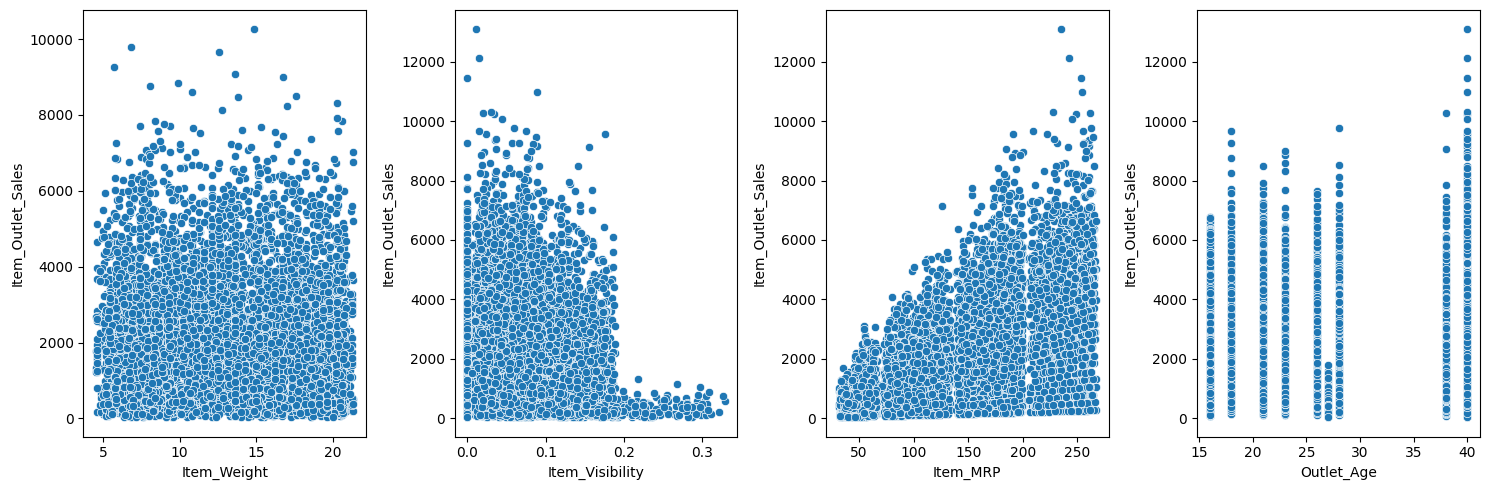

In [91]:
fig, axes = plt.subplots(1,4, figsize=(15, 5))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.scatterplot(x=df[col], y='Item_Outlet_Sales', data = df, ax=axes[i])
plt.tight_layout()
plt.show()

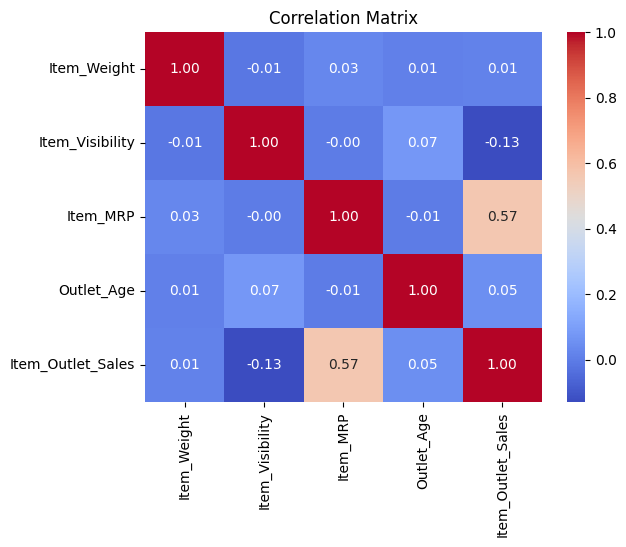

In [92]:
sns.heatmap(df[num_cols + ['Item_Outlet_Sales']].corr(),annot=True,cmap='coolwarm',fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### Conclusion

Based on both univariate and multivariate analysis, several key insights were identified:

**Categorical Features**
- Item_Fat_Content contains inconsistent labels (e.g., LF, low-fat, reg), indicating the need for standardization prior to modeling.
- Item_Type shows variation in sales performance, with categories such as Starchy Foods and Seafood achieving higher average sales.
- Outlet-related variables (Outlet_Identifier, Outlet_Size, Outlet_Location_Type, and Outlet_Type) exhibit significant influence on sales, highlighting the importance of store characteristics. Among them, Outlet_Type is the most influential categorical feature.

**Numerical Features**
- Item_MRP is the most influential numerical variable, showing a strong positive relationship with Item_Outlet_Sales.
- Item_Visibility demonstrates a weak negative and non-linear relationship with sales and contains abnormal zero values requiring preprocessing.
- Item_Weight shows minimal impact on sales.
- Outlet_Age does not have a strong linear relationship with sales.

Overall, the weak linear correlations among numerical features and the presence of
non-linear relationships suggest that tree-based models are more suitable than linear
models for this prediction task.


## Data Pre-processing

In [93]:
# fill weight missing values with mean
df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True)

In [94]:
# replace inconsistent categories
df['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'},inplace=True)

In [95]:
#check unique values in Outlet_Size per Outlet_Type
check = df.groupby('Outlet_Type')['Outlet_Size'].unique()
check

Outlet_Type
Grocery Store                      [nan, Small]
Supermarket Type1    [Medium, High, nan, Small]
Supermarket Type2                      [Medium]
Supermarket Type3                      [Medium]
Name: Outlet_Size, dtype: object

In [96]:
# fill missing Outlet_Size values based on Outlet_Type
df.loc[(df['Outlet_Type'] == 'Grocery Store') & (df['Outlet_Size'].isna()),'Outlet_Size'] = 'Small'

In [97]:
#fill missing Outlet_Size with mode
df['Outlet_Size'].fillna(df['Outlet_Size'].mode()[0],inplace=True)

In [98]:
#replace 0 with median visibility
df['Item_Visibility'] = df['Item_Visibility'].replace(0, np.nan)
df['Item_Visibility'] = (df.groupby('Item_Type')['Item_Visibility'].transform(lambda x: x.fillna(x.median())))

In [99]:
# #remove outliers
# column_names = ['Item_Visibility']

# for col in column_names:
#     Q1 = df[col].quantile(0.25)
#     Q3 = df[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
# df.head()

Although outlier removal was initially considered using the IQR method, model evaluation results showed improved performance when outliers were retained. This suggests that extreme values in  Item_Visibility likely represent genuine business scenarios (e.g., promotions or high-demand products) rather than noise.

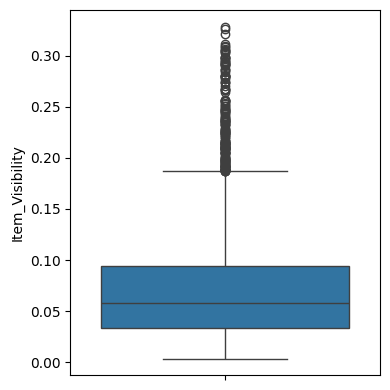

In [100]:
fig, axes = plt.subplots(figsize=(4, 4))
sns.boxplot(df['Item_Visibility'])
plt.tight_layout()
plt.show()

## Encoding Categorical Variables

In [101]:
cat_le=['Item_Fat_Content','Outlet_Location_Type','Outlet_Type']
cat_oe=['Outlet_Size']
cat_ohe=['Item_Type','Outlet_Identifier']

In [102]:
# encoding the values with the label encoder
le=LabelEncoder()
for col in cat_le:
    df[col]=le.fit_transform(df[col])

In [103]:
# encoding the values with the ordinal encoder
oe=OrdinalEncoder(categories=[['Small', 'Medium', 'High']])
df[cat_oe]=oe.fit_transform(df[cat_oe])

In [104]:
# encoding the values with the one hot encoder
ohe=OneHotEncoder(sparse_output=False)
encoded = ohe.fit_transform(df[cat_ohe])

ohe_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(cat_ohe), index=df.index)
df = pd.concat([df.drop(columns=cat_ohe), ohe_df], axis=1)

Categorical variables were encoded using different strategies depending on their characteristics:
- Ordinal encoding was applied to variables with natural ordering such as Outlet_Size and Outlet_Location_Type. 
- One-hot encoding was used for nominal variables including Item_Type and Outlet_Type. 
- Item_Fat_Content, Outlet_Location_Type, Outlet_Type were standardized and label-encoded due to its low cardinality. 

These encoding choices ensure compatibility with tree-based models and preserve important structural information in the data.


## Train-Test Split

In [105]:
X=df.drop(columns='Item_Outlet_Sales',axis=1)
Y = df['Item_Outlet_Sales']

Split the data into training and test sets, and fit the tree to the training data. Here we use 20% of the data for the test set and 80% for the train set.

In [106]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Modeling Selection and Training

In [107]:
def evaluate_model(Y_true, Y_pred):
    return {
        'MAE': metrics.mean_absolute_error(Y_true, Y_pred),
        'MSE': metrics.mean_squared_error(Y_true, Y_pred),
        'RMSE': math.sqrt(metrics.mean_squared_error(Y_true, Y_pred)),
        'R2': metrics.r2_score(Y_true, Y_pred)}

#### Linear Regression (Baseline Model)

Linear Regression was implemented as a baseline model to evaluate whether linear relationships between features and sales are sufficient for prediction. This model serves as a reference point to compare against more complex tree-based models.

In [108]:
scale = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scale.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scale.transform(X_test[num_cols])

In [109]:
lr = LinearRegression()
lr.fit(X_train_scaled, Y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [110]:
lr_y_pred = lr.predict(X_test_scaled)
lr_results = evaluate_model(Y_test, lr_y_pred)  
lr_results

{'MAE': 791.5895073346401,
 'MSE': 1142859.405206663,
 'RMSE': 1069.046025766273,
 'R2': 0.5795172951888787}

- The Linear Regression model achieved R² ≈ 0.5795 RMSE ≈ 1069. 
- The relatively low R² value indicates that linear relationships alone are insufficient to fully explain the variability in sales.

In [111]:
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', ascending=False)

coef_df.head(10)

,Feature,Coefficient
3,Item_MRP,979.411774
6,Outlet_Type,854.592330
30,Outlet_Identifier_OUT035,479.119683
26,Outlet_Identifier_OUT017,394.029783
25,Outlet_Identifier_OUT013,361.911387
31,Outlet_Identifier_OUT045,307.753910
29,Outlet_Identifier_OUT027,247.505597
20,Item_Type_Seafood,217.904135
4,Outlet_Size,205.443296
32,Outlet_Identifier_OUT046,172.436924


The coefficients indicate that **Item_MRP** has the strongest positive linear impact on sales, while other numerical variables show relatively weak effects.
However, interpretation should be treated with caution due to multicollinearity and non-linear relationships in the data.


Linear Regression provides a useful baseline for comparison but demonstrates limited predictive performance due to the non-linear nature of the data.
Therefore, more flexible models such as tree-based algorithms are required to capture complex feature interactions and improve prediction accuracy.

#### Random Forest Regressor

Random Forest was selected due to its robustness,ability to handle non-linear relationships, and resistance to overfitting.

Unlike linear models, Random Forest does not require feature scaling and can naturally capture interactions between variables.

In [112]:
rf=RandomForestRegressor(random_state=42, n_jobs=-1)

GridSearchCV was applied to identify the optimal hyperparameters for the Random Forest model using 5-fold cross-validation and R2 as the evaluation metric.

In [113]:
param_grid_rf = {
    'n_estimators': [400,500],
    'max_depth': [15,20],
    'min_samples_split': [2,3],
    'min_samples_leaf': [3,4],
    'max_features': ['sqrt', 'log2']
    }

grid_rf = GridSearchCV(rf, param_grid_rf, cv = 5, scoring='r2', n_jobs=-1)

grid_rf.fit(X_train, Y_train)
grid_rf.best_estimator_

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",500
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",3
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsampl

In [114]:
rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=3,
    max_features='sqrt'
)
rf.fit(X_train,Y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",500
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",3
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsampl

In [115]:
rf_pred = rf.predict(X_test)
rf_results = evaluate_model(Y_test, rf_pred)
rf_results

{'MAE': 740.7220558669858,
 'MSE': 1087735.390788974,
 'RMSE': 1042.9455358689513,
 'R2': 0.5997986128879754}

- After hyperparameter tuning, Random Forest shows a clear improvement over the baseline Linear Regression model.
- This model achieved R² ≈ 0.5998 and RMSE ≈ 1042
- The reduction in RMSE indicates that ensemble bagging effectively captures non-linear relationships while maintaining model stability and reducing variance.

#### XGBoost Regressor

XGBoost was implemented to further improve prediction performance usinggradient boosting techniques. By sequentially correcting previous errors, XGBoost can capture complex patterns and reduce bias more effectively than bagging- models.

In [116]:
xgb=XGBRegressor()

XGBoost was tuned using GridSearchCV to evaluate whether gradient boosting could further improve predictive performance by learning complex patterns and reducing model bias.

In [117]:
param_grid_xgb = {
    'n_estimators': [200, 400],
    'max_depth': [3,4],
    'min_child_weight': [1, 3],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'gamma': [0, 0.1],
    'colsample_bytree': [0.8, 1.0]}

grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv = 5, scoring='r2', n_jobs=-1)

grid_xgb.fit(X_train, Y_train)
grid_xgb.best_params_

{'colsample_bytree': 1.0,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 200,
 'subsample': 1.0}

In [118]:
xgb = XGBRegressor(
    gamma= 0,
    learning_rate= 0.05,
    max_depth= 3,
    min_child_weight= 1,
    n_estimators= 200,
    subsample= 1.0,
    colsample_bytree=  1.0)

xgb.fit(X_train, Y_train)


,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,1.0
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_meth

In [119]:
xgb_pred = xgb.predict(X_test)
xgb_results = evaluate_model(Y_test, xgb_pred)
xgb_results

{'MAE': 716.8834118985786,
 'MSE': 1055618.5010202152,
 'RMSE': 1027.4329666796832,
 'R2': 0.6116151115916338}

- XGBoost achieved the best performance with R² ≈ 0.6116 and RMSE ≈ 1027
- XGBoost outperforms Random Forest by achieving a lower RMSE and higher R² score. This demonstrates the advantage of boosting methods in learning complex non-linear relationships and correcting residual errors from previous models.